Here we will want to benchmark a few distance metrics to see how they perform.  Let's import all of the necessary modules.

In [1]:
import qiime2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gneiss.util import match
from skbio import DistanceMatrix
from skbio.stats.composition import closure

%matplotlib inline

The OTU tables that we will be analyzing are in a qiime2 archive format, so we'll want to extract those contents.

In [2]:
table = qiime2.Artifact.load('16S_table.biom.qza').view(pd.DataFrame)

table = table.loc[:, table.sum(axis=0)>0]

metadata = pd.read_table('sample_prep.txt', index_col=0, na_values='Not applicable')

metadata = metadata.loc[pd.notnull(metadata['grid_position'])]
# extract only the bonde cheese
metadata = metadata.loc[metadata['ANONYMIZED_NAME']=='Bonde']

# convert the rows and columns into numbers
metadata['grid_column'] = metadata.grid_position.apply(lambda x: ord(x[0])-ord('A'))
metadata['grid_row'] = metadata.grid_position.apply(lambda x: x[1:])
metadata['grid_row'] = metadata.grid_row.astype(np.int)
metadata['grid_column'] = metadata.grid_column.astype(np.int)

table, metadata = match(table, metadata)

Here we will be analyzing a goat cheese - the rows are numbered, and the columns have letters. See the image below.
<img src="files/bonde_cheese.png">

Let's now define our distance metrics.  Jenssen Shannon divergence can be defined using the symmetric KL divergence. Note that this is still a divergence - in order to convert this to an actual distance, we need to take the square root of that. This is given by

$$ d_{jsd}(x, y) = \sqrt{\frac{1}{2}\sum\limits_i x_i \log( \frac{x_i}{a_i} ) + y_i \log( \frac{y_i}{a_i} )}$$

where $a = \frac{1}{2}(x + y)$

Since there are some issues with zeros in the KL divergence, we'll be adding a pseudocount of 0.000001

In [3]:
# Jenssen Shannon Distance
from scipy.stats import entropy
def KL(x, y):
    idx = np.logical_or(x>0, y>0)
    return entropy(x[idx], y[idx])
jsd = lambda x, y: np.sqrt(0.5 * (KL(x,0.5*(x+y)) + KL(y,0.5*(x+y))))

The L1 distance is given by

$$ d_{L1}(x, y) = \sum\limits |x_i - y_i|$$

In [4]:
# L1 distance
from scipy.spatial.distance import cityblock
L1 = cityblock

The L2 distance (also known as Euclidean distance) is given by

$$ d_{L2}(x, y) = \sum\limits (x_i - y_i)^2$$

In [5]:
# L2 distance
from scipy.spatial.distance import euclidean
L2 = euclidean

Finally, the Aitchison distance is given by

$$ d_a(x, y) = \sqrt{\frac{1}{2D}\big( \log \frac{x_i}{x_j} - \log \frac{y_i}{y_j}\big)^2}$$

Another way to formulate this is using the clr transform given by

$$ clr(x) = \big[ \log \frac{x_1}{g(x)}, \ldots , \log \frac{x_D}{g(x)} \big ]$$

Where $g(x) = \big( x_1 x_2 \cdots x_D \big)^{(\frac{1}{D})}$ is the geometric mean.

Then the Aitchison distance is just the euclidean distance between clr transformed vectors

$$ d_a(x, y) = d_{L2}(clr(x), clr(y))$$

We will be using this formulation, since it is much easier to calculate.  Note that this distance cannot handle zeros
so we'll be adding a pseudocount of 0.000001 to the probabilities.

In [6]:
# Aitchison distance
from skbio.stats.composition import clr, multiplicative_replacement
aitchison = lambda x, y: euclidean(clr(multiplicative_replacement(x, delta=0.000001)), 
                                   clr(multiplicative_replacement(y, delta=0.000001)))

Now let's generate the distance matrices.  Now that we are going to use the closure function, just to normalize the counts to proportions.

In [7]:
jsd_dm = DistanceMatrix.from_iterable(closure(table.values), jsd)
L1_dm = DistanceMatrix.from_iterable(closure(table.values), L1)
L2_dm = DistanceMatrix.from_iterable(closure(table.values), L2)
aitchison_dm = DistanceMatrix.from_iterable(table.values, aitchison)

jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)
L1_dm = pd.DataFrame(L1_dm.data, index=table.index, columns=table.index)
L2_dm = pd.DataFrame(L2_dm.data, index=table.index, columns=table.index)
aitchison_dm = pd.DataFrame(aitchison_dm.data, index=table.index, columns=table.index)

Let's first look at the distances between all of the neighboring squares

In [8]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row)):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

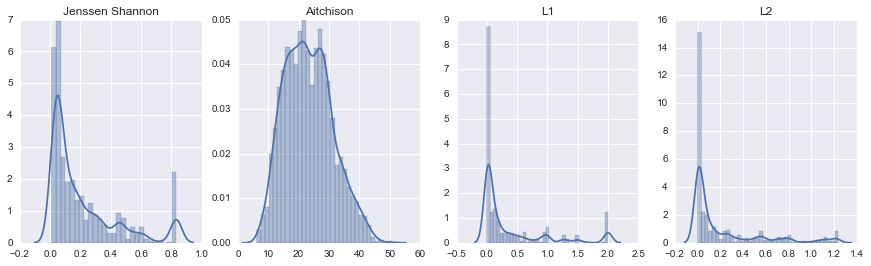

In [9]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

jsd_distances = np.array([jsd_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(jsd_distances, ax=axes[0])
axes[0].set_title('Jenssen Shannon')

aitchison_distances = np.array([aitchison_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(aitchison_distances, ax=axes[1])
axes[1].set_title('Aitchison')
    
L1_distances = np.array([L1_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L1_distances, ax=axes[2])
axes[2].set_title('L1')

L2_distances = np.array([L2_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L2_distances, ax=axes[3])
axes[3].set_title('L2')

Now, we will be only analyzing rows 5 through 13 -- we will want to only look at cross sections of the cheese that cut through the microbial gradients (i.e. we don't want rows with just rind).

Finally, let's extract the distances.  We'll only focus on the distances starting at column E, since it is in the middle of the cheese.  

In [10]:
# extract rows 5 through 13
idx = np.logical_and(metadata['grid_row'] > 5, metadata['grid_row'] < 13)
metadata = metadata.loc[idx]

# match up the rows of the metadata and the OTU table to make sure that they are in the same order
table, metadata = match(table, metadata)

Now we'll plot each row separately as its own color.

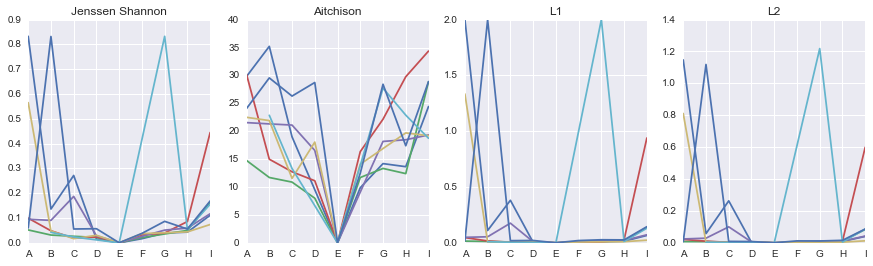

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[0].plot(md.grid_column, jsd_dm.loc[n, md.index], label='row_%s' % n)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_title('Jenssen Shannon')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[1].plot(md.grid_column, aitchison_dm.loc[n, md.index], label='row_%s' % n)    
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_title('Aitchison')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[2].plot(md.grid_column, L1_dm.loc[n, md.index], label='row_%s' % n)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].set_title('L1')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[3].plot(md.grid_column, L2_dm.loc[n, md.index], label='row_%s' % n)
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(labels)
    axes[3].set_title('L2')


The property distinguishes the Aitchison distance from the other distance metrics is known as subcompositional coherence.  This property is given as follows

$d(x_s, y_s) \leq d(x, y)$

For some indexing vector $s$ that chooses a subcomposition of $x$ and $y$.
Basically what this says is that when you calculating the distance between $x$ and $y$, if you only consider a smaller subspace with fewer dimensions, then the distance betwee the subcomponents of $x$ and $y$ will be smaller.

Let's perform some bootstraps to further investigate this.  We'll bootstrap the samples and compute the means of the distances.

### Yoav's Clarification 

#### What I mean by "a bootstrap sample"

Let `X` represent a sample. By this I *do not* mean a vector of counts: 
* (Species 1, Count 1), (Species 2, Count 2). 

Rather, I mean a long vector of species:  
* Species 1, Species 5332, Species 2, Species 1, .....

The length of `X` is the total count, lets call that `N`.

To generate a bootstrap sample from the vector `X` I would use 

```python
S=choice(X,size=N,replace=True).
```

This generates a new sample `S` which is a variant of `X`. Note that this is quite different from sampling the coordinates. In particular, if you have a coordinate (species) with a high count, then the count of the same species in `S` will be similar. On the other hand, if the count in `X` is 1 or 2, it is quite likely that the species will not appear at all in `S`. This simulates the low-count problem.

below I am writing a function that generates `k` bootstrap samples from a single distribution.

If `N` is very large, then we might need to write a more sophisticated function, whose performance scales with the number of species and not the total count.

In [11]:
from numpy.random import choice
from collections import Counter

def bootstrap(D,k=10):
    """
    Compute k bootstrap distributions from a given distribution.
    input: D: a dictionary that defines a distribution key = species, value=count.
    """
    X=[]
    for species in D.keys():
        X+=[species]*D[species]
    N=len(X)
    B=[]
    for i in range(k):
        S=choice(X,size=N,replace=True)
        B.append(dict(Counter(S)))
    return B
Dist={1:10,2:1,10:3,12:2}
bootstrap(Dist)

[{1: 12, 10: 3, 12: 1},
 {1: 8, 2: 1, 10: 4, 12: 3},
 {1: 10, 10: 4, 12: 2},
 {1: 10, 2: 1, 10: 3, 12: 2},
 {1: 13, 10: 2, 12: 1},
 {1: 10, 2: 2, 10: 1, 12: 3},
 {1: 10, 2: 1, 10: 3, 12: 2},
 {1: 10, 2: 2, 10: 4},
 {1: 14, 10: 1, 12: 1},
 {1: 9, 10: 4, 12: 3}]

In [2]:
from numpy.random import choice

# Scaling function
def scaling_function(f, x, y, k=100, N=10000):
    ds = np.zeros(k)
    for i in range(k):
        xs = choice(x, size=N)
        ys = choice(y, size=N)
        ds[i] = f(xs, ys)
    return ds.mean()

In [3]:
choice?

Now we will calculate the pairwise distances.  Note that the distance now aren't guaranteed to be symmetric (since the are now just expectations).

In [25]:
from skbio.stats.distance import DissimilarityMatrix

jsd_scaled = lambda x, y: scaling_function(jsd, x, y)
L1_scaled = lambda x, y: scaling_function(L1, x, y)
L2_scaled = lambda x, y: scaling_function(L2, x, y)
aitchison_scaled = lambda x, y: scaling_function(aitchison, x, y)

jsd_dm = DissimilarityMatrix.from_iterable(closure(table.values), jsd_scaled)
L1_dm = DissimilarityMatrix.from_iterable(closure(table.values), L1_scaled)
L2_dm = DissimilarityMatrix.from_iterable(closure(table.values), L2_scaled)
aitchison_dm = DissimilarityMatrix.from_iterable(table.values, aitchison_scaled)

jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)
L1_dm = pd.DataFrame(L1_dm.data, index=table.index, columns=table.index)
L2_dm = pd.DataFrame(L2_dm.data, index=table.index, columns=table.index)
aitchison_dm = pd.DataFrame(aitchison_dm.data, index=table.index, columns=table.index)

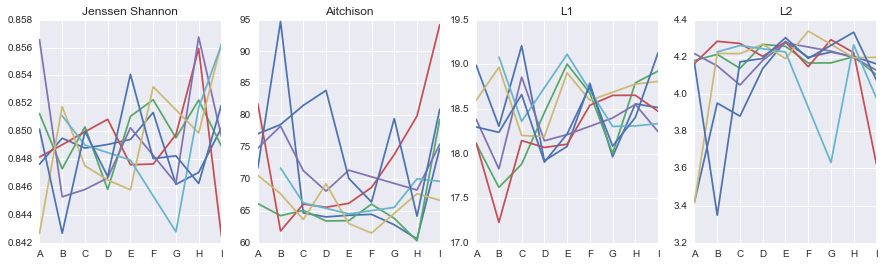

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[0].plot(md.grid_column, jsd_dm.loc[n, md.index], label='row_%s' % n)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_title('Jenssen Shannon')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[1].plot(md.grid_column, aitchison_dm.loc[n, md.index], label='row_%s' % n)    
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_title('Aitchison')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[2].plot(md.grid_column, L1_dm.loc[n, md.index], label='row_%s' % n)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].set_title('L1')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[3].plot(md.grid_column, L2_dm.loc[n, md.index], label='row_%s' % n)
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(labels)
    axes[3].set_title('L2')

In [27]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row)):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

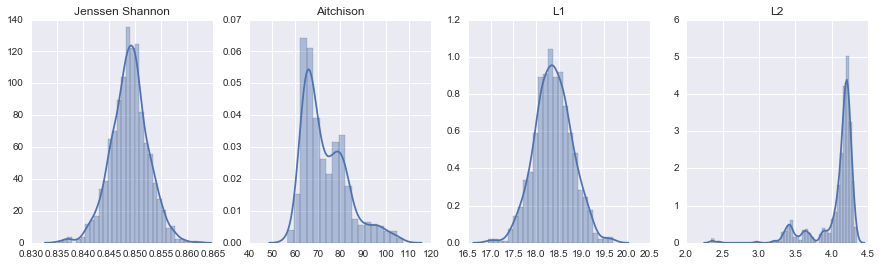

In [28]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

jsd_distances = np.array([jsd_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(jsd_distances, ax=axes[0])
axes[0].set_title('Jenssen Shannon')

aitchison_distances = np.array([aitchison_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(aitchison_distances, ax=axes[1])
axes[1].set_title('Aitchison')
    
L1_distances = np.array([L1_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L1_distances, ax=axes[2])
axes[2].set_title('L1')

L2_distances = np.array([L2_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L2_distances, ax=axes[3])
axes[3].set_title('L2')

In [1]:
# Scaling function
def scaling_function(f, x, y, k=100, N=10000):
    ds = np.zeros(k)
    for i in range(k):
        xs = choice(x, size=N)
        ys = choice(y, size=N)
        ds[i] = f(xs, ys)
    return ds

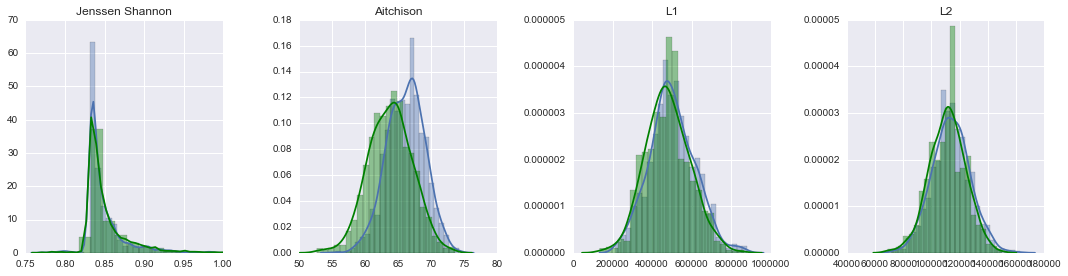

In [50]:
jsd_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                             y=table.loc['bonde.E7'], k=1000) 
L1_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
L2_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
aitchison_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                   y=table.loc['bonde.E7'], k=1000)

jsd_same_boots = scaling_function(jsd, x=table.loc['bonde.E7'], 
                                  y=table.loc['bonde.E7'], k=1000) 
L1_same_boots = scaling_function(L1, x=table.loc['bonde.E7'], 
                                 y=table.loc['bonde.E7'], k=1000)
L2_same_boots = scaling_function(L2, x=table.loc['bonde.E7'], 
                                 y=table.loc['bonde.E7'], k=1000)
aitchison_same_boots = scaling_function(aitchison, x=table.loc['bonde.E7'],
                                        y=table.loc['bonde.E7'], k=1000)

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

sns.distplot(jsd_boots, ax=axes[0])
sns.distplot(jsd_same_boots, ax=axes[0], color='green')
axes[0].set_title('Jenssen Shannon')
axes[0].set_xlim([0.75, 1.0])
sns.distplot(aitchison_boots, ax=axes[1])
sns.distplot(aitchison_same_boots, ax=axes[1], color='green')
axes[1].set_title('Aitchison')
    
sns.distplot(L1_boots, ax=axes[2])
sns.distplot(L1_same_boots, ax=axes[2], color='green')
axes[2].set_title('L1')

sns.distplot(L2_boots, ax=axes[3])
sns.distplot(L2_same_boots, ax=axes[3], color='green')
axes[3].set_title('L2')
plt.tight_layout()


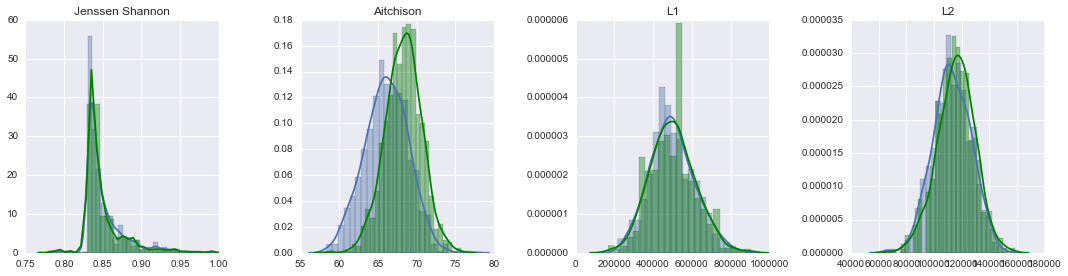

In [51]:
jsd_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                             y=table.loc['bonde.E7'], k=1000) 
L1_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
L2_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
aitchison_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                   y=table.loc['bonde.E7'], k=1000)

jsd_same_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                                  y=table.loc['bonde.A7'], k=1000) 
L1_same_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                                 y=table.loc['bonde.A7'], k=1000)
L2_same_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                                 y=table.loc['bonde.A7'], k=1000)
aitchison_same_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                        y=table.loc['bonde.A7'], k=1000)

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

sns.distplot(jsd_boots, ax=axes[0])
sns.distplot(jsd_same_boots, ax=axes[0], color='green')
axes[0].set_title('Jenssen Shannon')
axes[0].set_xlim([0.75, 1.0])
sns.distplot(aitchison_boots, ax=axes[1])
sns.distplot(aitchison_same_boots, ax=axes[1], color='green')
axes[1].set_title('Aitchison')
    
sns.distplot(L1_boots, ax=axes[2])
sns.distplot(L1_same_boots, ax=axes[2], color='green')
axes[2].set_title('L1')

sns.distplot(L2_boots, ax=axes[3])
sns.distplot(L2_same_boots, ax=axes[3], color='green')
axes[3].set_title('L2')
plt.tight_layout()